Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
#%pip install pandahouse
#%pip install seaborn
#%pip install swifter
#%pip install scipy

In [2]:
import pandas as pd
import pandahouse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import swifter
import hashlib
from scipy import stats
%matplotlib inline

In [43]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '********',
    'user': '********',
    'database': 'simulator_20230720'
}

q = """
SELECT  DISTINCT user_id ,
        exp_group,
        sum(action = 'like') likes,
        sum(action = 'view') views,
        likes/views ctr
FROM simulator_20230720.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1, 2)
GROUP by exp_group, user_id
"""

users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [44]:
print(f'Количественное соотношение юзеров в интересующих группах (1, 2):')
users_df[['user_id', 'exp_group']].groupby('exp_group').count()

Количественное соотношение юзеров в интересующих группах (1, 2):


,user_id
exp_group,
1,10020
2,9877


# Посмотрим на распредление CTR в 1 и 2 группе

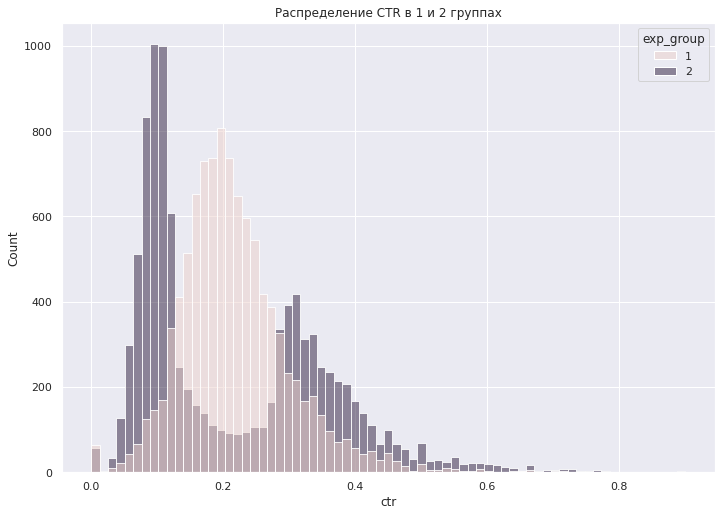

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = users_df,
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 1 и 2 группах')
plt.show()

In [46]:
users_df[['ctr', 'exp_group']].groupby('exp_group').describe()

ctr                                                         \
             count      mean       std  min       25%       50%       75%   
exp_group                                                                   
1          10020.0  0.216774  0.082969  0.0  0.163636  0.205882  0.257870   
2           9877.0  0.216102  0.142870  0.0  0.096774  0.153285  0.323529   

                     
                max  
exp_group            
1          0.722222  
2          0.900000

* Из графика видим, что CTR в экспериментальной группе (2) имеет двугорбое распредление. Первый пик гистограммы значительно выше, соответствует CTR ~ 0.1. Второй пик соответствует CTR ~ 0.35. Вогнутость гистограммы располагается под пиком CTR для контрольной группы. 
* Среднее значение CTR по всей экспериментальной группе осталось близко к среднему CTR контрольной группы. 
* Половина пользователей из экспериментальной группы имеет CTR до 0.15, четверть пользователей - до 0.0967, что меньше, чем в контрольной группе. 
* Новая рекомендательная система повлияла на кликабельность постов, скорее, в худшую сторону.

## t-тест

In [182]:
t_test = stats.ttest_ind(users_df[users_df.exp_group == 1].ctr,
                         users_df[users_df.exp_group == 2].ctr,
                         equal_var=False)
print(t_test)
if t_test[1] < 0.05:
    print(f'нулевая гипотеза Н0 НЕ ВЕРНА => средние CTR в группах 1 и 2 отличаются')
else:
    print(f'нулевая гипотеза Н0 ВЕРНА => средние CTR в группах 1 и 2 НЕ отличаются')

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)
нулевая гипотеза Н0 ВЕРНА => средние CTR в группах 1 и 2 НЕ отличаются


По итогам t-теста мы не можем отвергнуть H0, так как p-value велико. Получается, согласно t-тесту, CTR в экспериментальной и контрольной группах одинаковы. Однако мы убедились ранее (на гистограмме распрпеделения CTR), что выборки существенно отличаются качественно, хоть и имеют близкое (с точностью до третьего знака) среднее значение. Совпадение средних значений выборок и привело к такому результату t-теста.

# Пуассонов бутстреп

In [127]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap_1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstrap_2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    global_ctr_1 = (likes1 * poisson_bootstrap_1).sum(axis=1) / (views1 * poisson_bootstrap_1).sum(axis=1)
    global_ctr_2 = (likes2 * poisson_bootstrap_2).sum(axis=1) / (views2 * poisson_bootstrap_2).sum(axis=1)
    
    return global_ctr_1, global_ctr_2


In [130]:
likes1 = users_df[users_df.exp_group == 1].likes.to_numpy()
likes2 = users_df[users_df.exp_group == 2].likes.to_numpy()
views1 = users_df[users_df.exp_group == 1].views.to_numpy()
views2 = users_df[users_df.exp_group == 2].views.to_numpy()

ctr_1, ctr_2 = bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000)

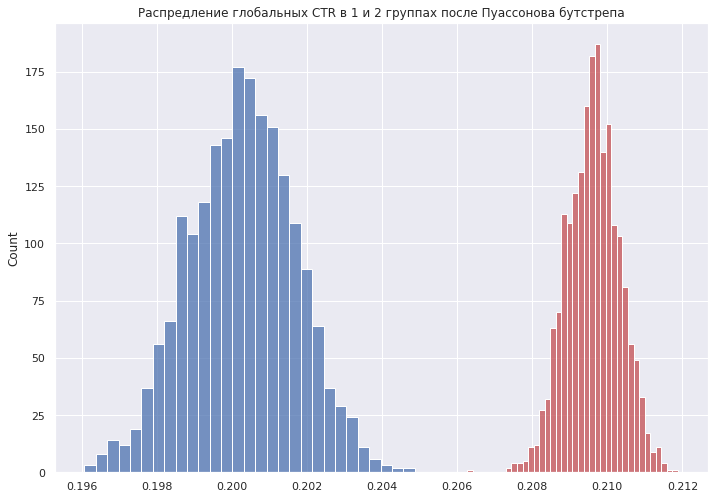

In [168]:
sns.histplot(ctr_1, color='r')
sns.histplot(ctr_2, color='b')
plt.title('Распредление глобальных CTR в 1 и 2 группах после Пуассонова бутстрепа')
plt.show()

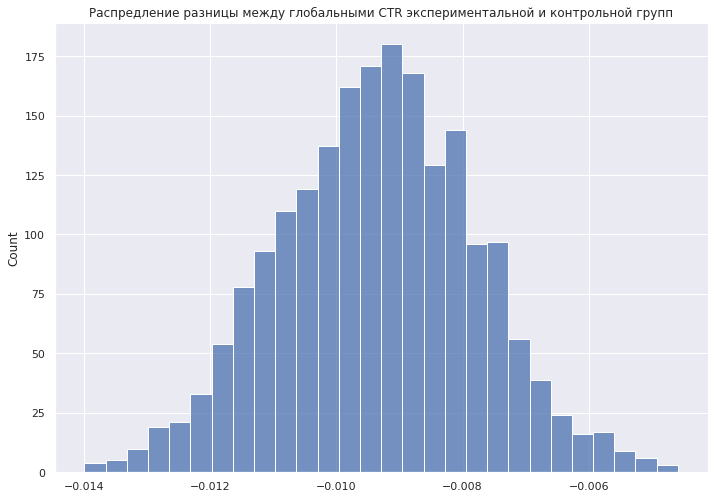

In [169]:
sns.histplot(ctr_2 - ctr_1)
plt.title('Распредление разницы между глобальными CTR экспериментальной и контрольной групп')
plt.show()

* Результаты применения пуассонова бутстрепа показывают, что глобальные CTR в экспериментальной и контрольной группах отличаются, причем разница отрицательна, следовательно, значения CTR пользователей с новой рексистемой ниже.
* Из визуального анализа распредлений, мы значем, что они отличаются, поэтому данный тест хорошо себя проявил.

# Тест Манна-Уитни

In [180]:
MW_test = stats.mannwhitneyu(users_df[users_df.exp_group == 1].ctr,
                   users_df[users_df.exp_group == 2].ctr,
                   alternative = 'two-sided')
print(MW_test)
if MW_test[1] < 0.05:
    print(f'нулевая гипотеза Манна-Уитни Н0 НЕ ВЕРНА => распределения CTR в группах 1 и 2 отличаются')
else:
    print(f'нулевая гипотеза Манна-Уитни Н0 ВЕРНА => распределения CTR в группах 1 и 2 НЕ отличаются')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
нулевая гипотеза Манна-Уитни Н0 НЕ ВЕРНА => распределения CTR в группах 1 и 2 отличаются


In [185]:
# Посмотрим какой % случаев, когда А>B
df = users_df
A_gt_B = 0
for i in range(15000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    if i == 1000:
        print('В', A_gt_B/i*100, '% случаев A > B. Для подтверждения H0 должно получиться около 50%')
    elif i == 5000:
        print('В', A_gt_B/i*100, '% случаев A > B. Для подтверждения H0 должно получиться около 50%')
    elif i == 10000:
        print('В', A_gt_B/i*100, '% случаев A > B. Для подтверждения H0 должно получиться около 50%')
    elif i == 15000:
        print('В', A_gt_B/i*100, '% случаев A > B. Для подтверждения H0 должно получиться около 50%')


В 0.54 % случаев A > B. Для подтверждения H0 должно получиться около 50%
В 0.5648 % случаев A > B. Для подтверждения H0 должно получиться около 50%
В 0.5576 % случаев A > B. Для подтверждения H0 должно получиться около 50%


* Тест Манна-Уитни показал, что распределения CTR в группах 1 и 2 отличаются. 
* Посмотрев на % случаев, когда CTR группы 1 больше CTR группы 2, можем сказать, что отличие двух групп незначительно. 
* На мой взгляд, этот тест в данном случае сработал лучше, чем t-тест, и подтверждает визуальный анализ распредлений.

# t-тест на сглаженном CTR

In [222]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = users_df[users_df.exp_group == 1].likes.sum()/users_df[users_df.exp_group == 1].views.sum()
global_ctr_2 = users_df[users_df.exp_group == 2].likes.sum()/users_df[users_df.exp_group == 2].views.sum()

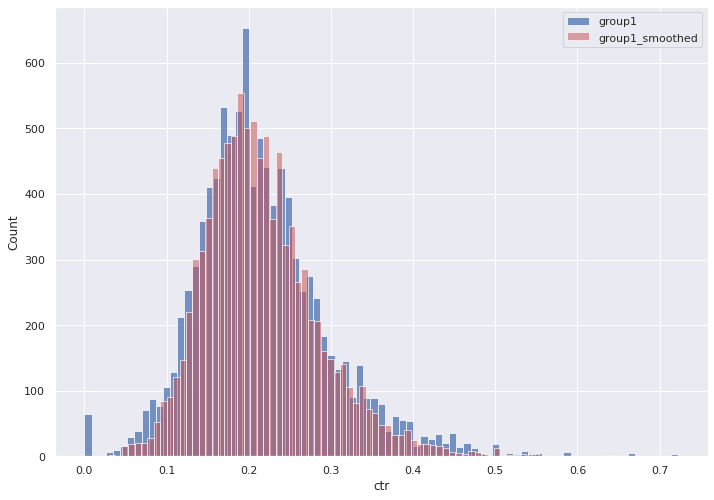

In [231]:
# Проиллюстрируем сглаженный CTR на 1 группе
group1 = users_df[users_df.exp_group == 1].copy()
hist = sns.histplot(group1.ctr, 
             kde = False,
             color = 'b')

group1['smothed_ctr'] = group1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

hist = sns.histplot(group1.smothed_ctr, 
             kde = False,
             color = 'r',
             alpha = 0.5)
hist.legend(['group1', 'group1_smoothed'])
plt.show()

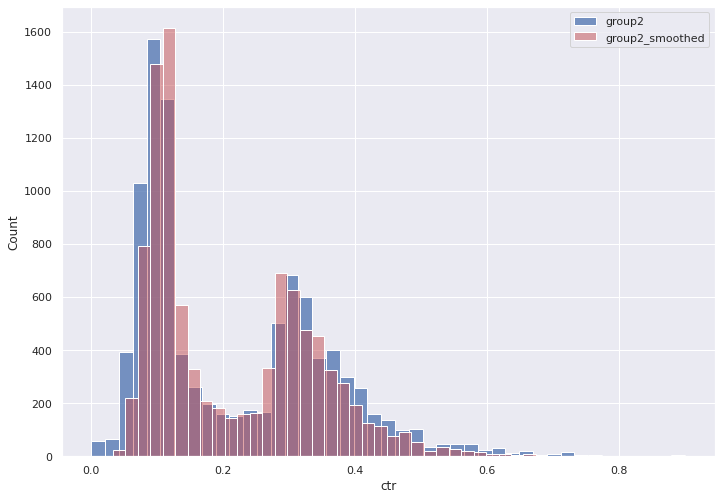

In [237]:
group2 = users_df[users_df.exp_group == 2].copy()
group2['smothed_ctr'] = group2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

hist = sns.histplot(group2.ctr, 
             kde = False,
             color = 'b')
hist = sns.histplot(group2.smothed_ctr, 
             kde = False,
             color = 'r',
             alpha = 0.5)
hist.legend(['group2', 'group2_smoothed'])
plt.show()

In [238]:
t_test = stats.ttest_ind(group1['smothed_ctr'],
                         group2['smothed_ctr'],
                         equal_var=False)
print(t_test)
if t_test[1] < 0.05:
    print(f'нулевая гипотеза Н0 НЕ ВЕРНА => средние сглаженных CTR в группах 1 и 2 отличаются')
else:
    print(f'нулевая гипотеза Н0 ВЕРНА => средние сглаженных CTR в группах 1 и 2 НЕ отличаются')

Ttest_indResult(statistic=1.2447034376197188, pvalue=0.2132595139151033)
нулевая гипотеза Н0 ВЕРНА => средние сглаженных CTR в группах 1 и 2 НЕ отличаются


* В результате t-теста со сглаженным CTR pvalue=0.213 (на исходном CTR было pvalue=0.685). 
* Итог t-теста на сглаженном CTR не отличается от первого t-теста: средние двух выборок также равны, хоть шумов и меньше.
* t-тест при данном распредлении метрик не стоит применять

## Бакетное преобразование

In [245]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

user_bucket = pandahouse.read_clickhouse(q, connection=connection)

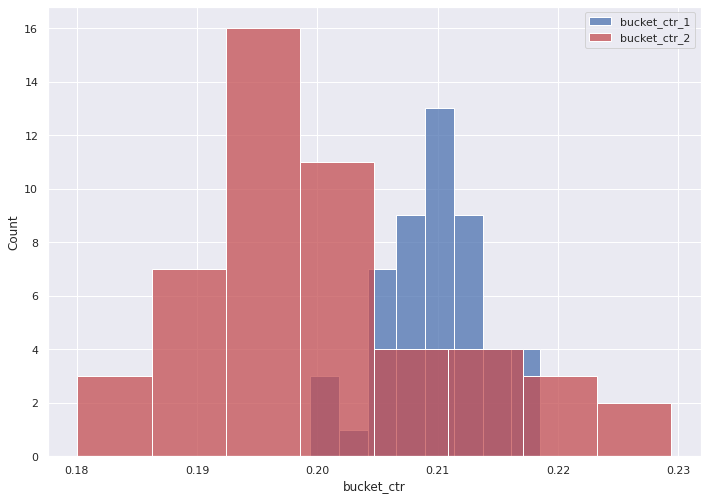

In [246]:
hist = sns.histplot(user_bucket[user_bucket.exp_group == 1].bucket_ctr, color='b')
hist = sns.histplot(user_bucket[user_bucket.exp_group == 2].bucket_ctr, color='r')
hist.legend(['bucket_ctr_1', 'bucket_ctr_2'])
plt.show()

* Из гистограммы CTR по бакетам видим, что распредления в 1 и 2 группах существенно отличаются

# t-тест

In [247]:
t_bucket = stats.ttest_ind(user_bucket[user_bucket.exp_group == 1].bucket_ctr, 
                           user_bucket[user_bucket.exp_group == 2].bucket_ctr, 
                           equal_var = False)
print(t_bucket)
if t_bucket[1] < 0.05:
    print(f'нулевая гипотеза Н0 НЕ ВЕРНА => средние сглаженных CTR в группах 1 и 2 отличаются')
else:
    print(f'нулевая гипотеза Н0 ВЕРНА => средние сглаженных CTR в группах 1 и 2 НЕ отличаются')

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)
нулевая гипотеза Н0 НЕ ВЕРНА => средние сглаженных CTR в группах 1 и 2 отличаются


# тест Манна-Уитни

In [248]:
MW_bucket = stats.mannwhitneyu(user_bucket[user_bucket.exp_group == 1].bucket_ctr, 
                               user_bucket[user_bucket.exp_group == 2].bucket_ctr, 
                               alternative = 'two-sided')

print(MW_bucket)
if MW_bucket[1] < 0.05:
    print(f'нулевая гипотеза Н0 НЕ ВЕРНА => средние сглаженных CTR в группах 1 и 2 отличаются')
else:
    print(f'нулевая гипотеза Н0 ВЕРНА => средние сглаженных CTR в группах 1 и 2 НЕ отличаются')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)
нулевая гипотеза Н0 НЕ ВЕРНА => средние сглаженных CTR в группах 1 и 2 отличаются


* t-тест и тест Манна-Уитни на бакетном преобразовании выборок CTR дают схожие результаты: CTR в группах отличается. 

# Выводы
## О характере распредления CTR:
* Визуально рапсредления CTR в экспериментальной (2) и контрольной (1) группах отличаются.
* CTR в экспериментальной группе имеет двугорбое распредление. Первый пик гистограммы значительно выше, соответствует CTR ~ 0.1. Второй пик соответствует CTR ~ 0.35. Вогнутость гистограммы располагается под пиком CTR для контрольной группы. Такой результат можно объяснить тем, что одной части аудитории 2 группы наше нововведение понравилось (лайки возросли), а другой - нет (лайки упали). Причем тех, кому не понравилось новшество оказалось больше. 
* Половина пользователей из экспериментальной группы имеет CTR до 0.15, четверть пользователей - до 0.0967, что меньше, чем в контрольной группе. 
* Почему такой эффект? Возможно, пользователям хочется более разнообразного контента, а не одннотипные посты.

## О результатах A/B тестов разными методами:
* t-test в классической постановке и на метрике сглаженного CTR не заметил различий в группах. Это связано с тем, что рассматриваемые распредления имеют практически одинаковое среднее значение.Данный тест здесь не применим.
* t-test поверх бакетного преобразования обнаружил разницу между группами, так как CTR, вычисленные внутри бакетов, заметнее отличаются, ввиду того, что бакеты наполняются данными без повтора и в меньшем количестве, чем размер исходной выборки.
* тест Манна-Уитни заметил различия выборок и на исходных данных, и поверх бакетного проебразования.
* Пуасснов бустсреп хорошо определил различия между выборками, более того, позволил определить улучшился ли CTR - не улучшился.

## Заключение
* Новая рекомендательная система повлияла на кликабельность постов в худшую сторону. Если будем распространять ее на всех пользователей, то вероятен отток аудитории.
* Возможно, имеет смысл увеличить время проведения эксперимента и провести  A/B тест еще раз.